In [1]:
%run init.ipy

from vtr.prior import formant
from lib import constants
from dgf import bijectors

2022-11-03 23:35:58.108770: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


[Memory]3.3s, 0.1min    : Loading get_aplawd_training_pairs...


[Memory]18.1s, 0.3min   : Loading run_nested...
[Memory]19.5s, 0.3min   : Loading run_nested...
[Memory]21.2s, 0.4min   : Loading run_nested...
[Memory]22.7s, 0.4min   : Loading run_nested...
[Memory]22.7s, 0.4min   : Loading get_aplawd_training_pairs...


[Memory]26.5s, 0.4min   : Loading get_vtrformants_training_data...
[Memory]34.7s, 0.6min   : Loading run_nested...
[Memory]35.6s, 0.6min   : Loading run_nested...
[Memory]36.4s, 0.6min   : Loading run_nested...
[Memory]37.3s, 0.6min   : Loading run_nested...
[Memory]37.3s, 0.6min   : Loading get_vtrformants_training_data...


## Implement Hawks (1995) $B(F)$ formula



In [2]:
def hawks_bandwidth(T, F):
    """Implement Hawks+ (1995) Eq. (1)"""
    if F < 500.:
        k  = 165.327516
        x1 = -6.73636734e-1
        x2 = 1.80874446e-03
        x3 = -4.52201682e-06
        x4 = 7.49514000e-09
        x5 = -4.70219241e-12
    else:
        k  = 15.8146139
        x1 = 8.10159009e-02
        x2 = -9.79728215e-05
        x3 = 5.28725064e-08
        x4 = -1.07099364e-11
        x5 = 7.91528509e-16
    F0 = 1000./T # Hz
    S = 1. + 0.25*(F0 - 132)/88
    B = S*(k + x1*F + x2*F**2 + x3*F**3 + x4*F**4 + x5*F**5)
    return B

hawks_bandwidth = np.vectorize(hawks_bandwidth)

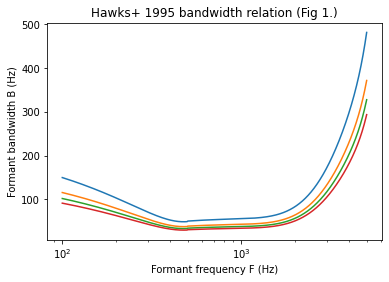

In [3]:
F = np.linspace(100, 5000, 1000)[:,None] # Hz
T = np.array([4., 7., 10., 15.])[None,:] # msec

plot(F, hawks_bandwidth(T, F))
xscale('log')
title("Hawks+ 1995 bandwidth relation (Fig 1.)")
ylabel("Formant bandwidth B (Hz)")
xlabel("Formant frequency F (Hz)");

## Get $p(T,F)$

In [4]:
data = formant.get_vtrformants_training_data()

TF = [np.column_stack(d[0:2]) for d in data]

a, b = constants.MIN_FORMANT_FREQ_HZ, constants.MAX_FORMANT_FREQ_HZ
bounds = jnp.array([
    (constants.MIN_PERIOD_LENGTH_MSEC, constants.MAX_PERIOD_LENGTH_MSEC),
    (a, b),
    (a, b),
    (a, b)
])

samples = np.vstack(TF)

bs, results = bijectors.fit_nonlinear_coloring_bijector(
    samples, bounds, 87846, return_fit_results=True
)

[Memory]40.0s, 0.7min   : Loading get_vtrformants_training_data...
[Memory]40.7s, 0.7min   : Loading run_nested...


## Regress and make a prior

We find ourselves in a textbook Maxent situation. We are only given in Hawks (1995) the expected value of absolute differences in dB. Therefore, our assigned prob distribution is Laplace.

In [5]:
HAWKS_ERRORS_DB = (1.15, 1.9, 3.2) # dB

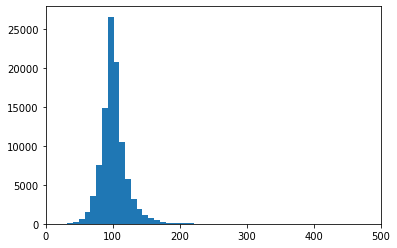

In [6]:
import scipy.stats

factor = 10**(scipy.stats.laplace(scale=HAWKS_ERRORS_DB[0]).rvs(100000)/20)*100.
hist(factor, bins=50)
xlim(0, 500);

In [115]:
%%time

NUMSAMPLES = 100000

TF = bs.forward(randn(NUMSAMPLES, 4))

T, F = np.hsplit(TF, (1,))
B_hawks = hawks_bandwidth(T, F)
errors = scipy.stats.laplace(scale=HAWKS_ERRORS_DB).rvs(size=(NUMSAMPLES,3))
B_true = B_hawks * 10**(errors/20)
TFB = np.column_stack((T, F, B_true))

CPU times: user 327 ms, sys: 23.7 ms, total: 351 ms
Wall time: 313 ms


In [128]:
max = np.array([20., 5000., 5000., 5000., 400., 400., 400.]) # FIXME

mask = np.all(TFB < max, axis=1)
TFB_masked = TFB[mask]

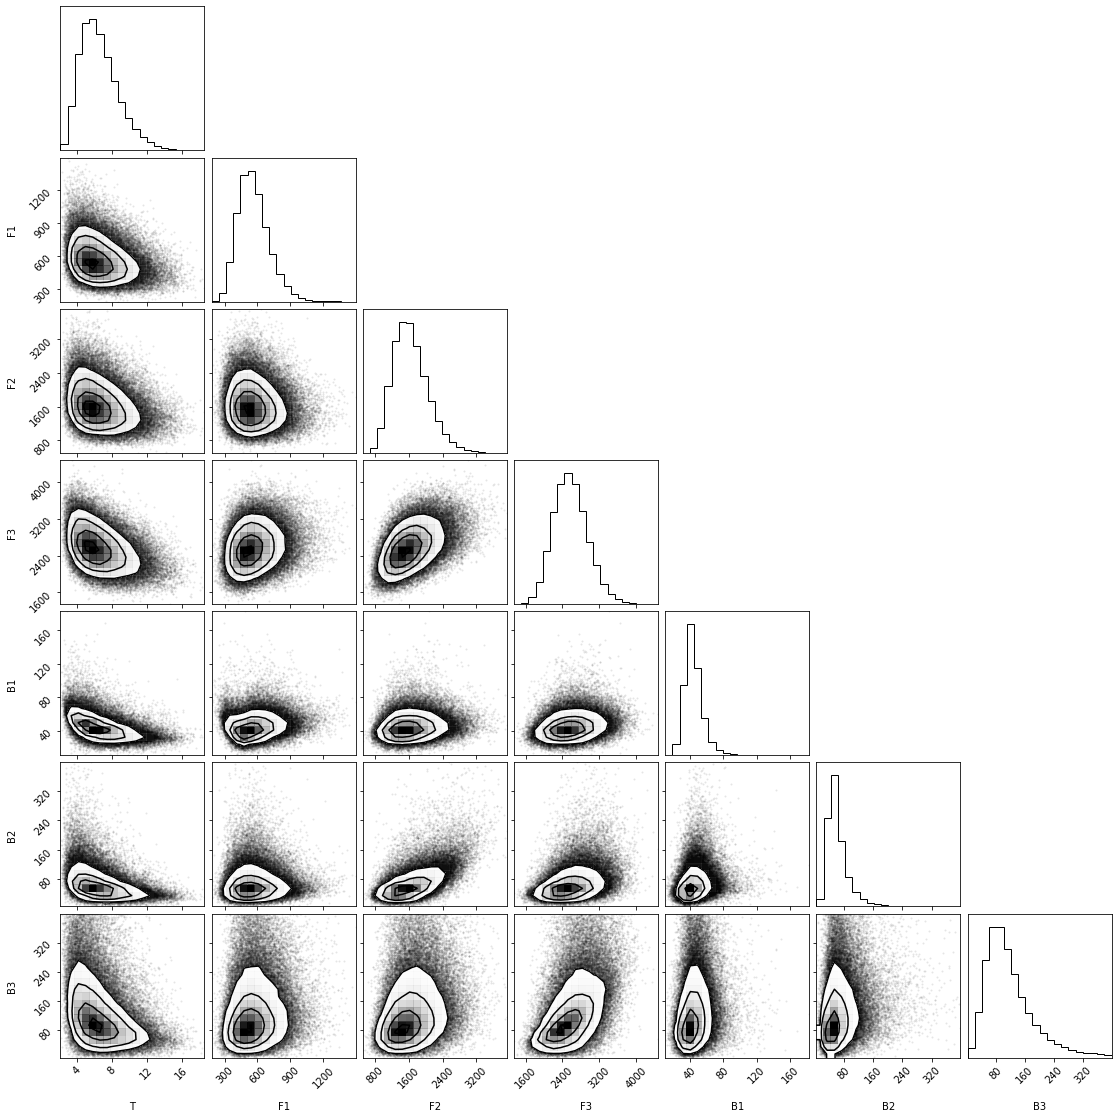

In [129]:
import corner

corner.corner(TFB_masked, labels=("T", "F1", "F2", "F3", "B1", "B2", "B3"));

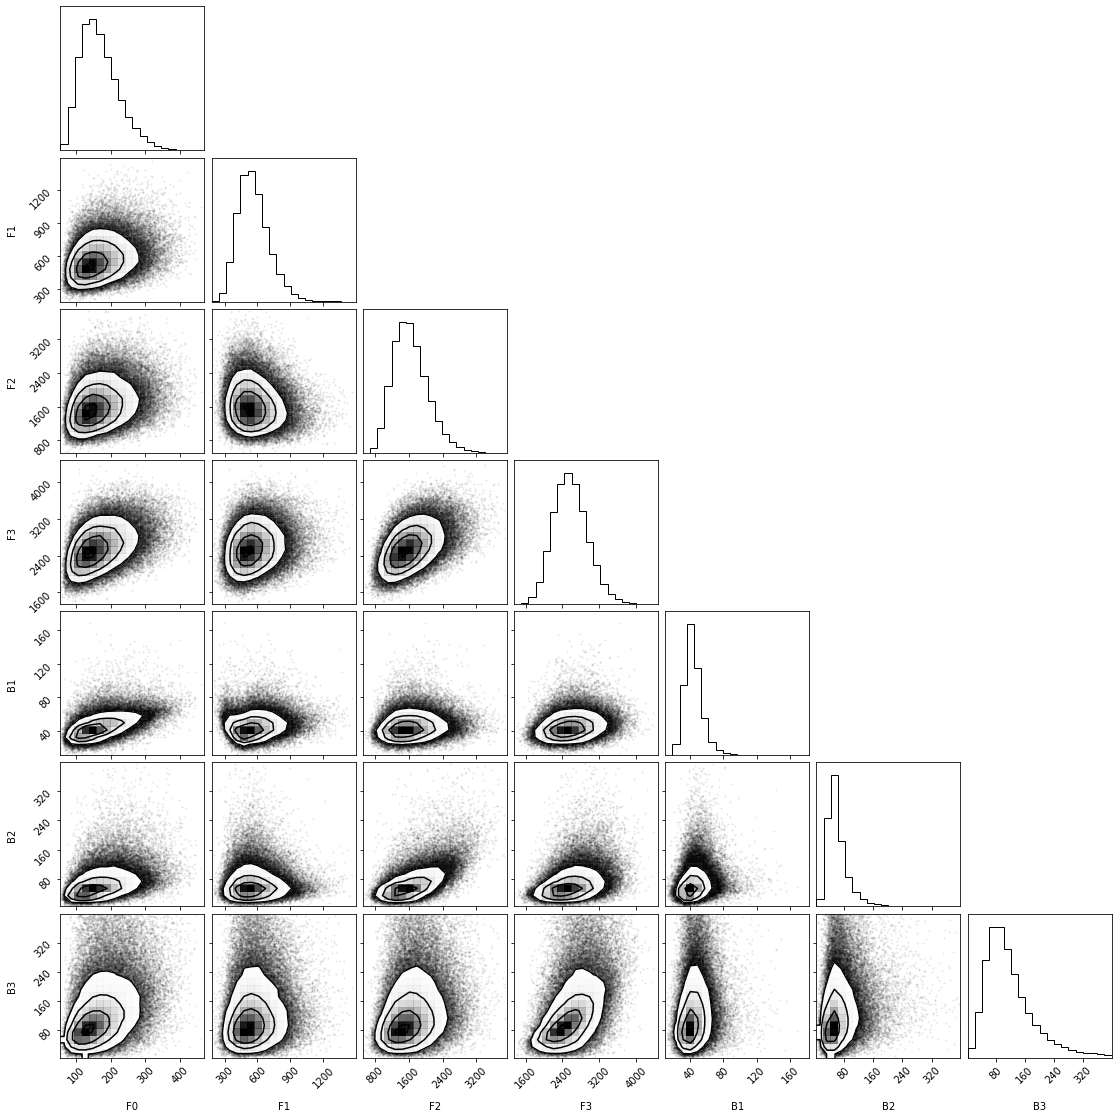

In [130]:
FFB_masked = np.column_stack((1000/TFB_masked[:,0],TFB_masked[:,1:]))

corner.corner(FFB_masked, labels=("F0", "F1", "F2", "F3", "B1", "B2", "B3"));

## Fit prior $p(T, F, B)$

In [132]:
np.min(TFB_masked, axis=0), np.max(TFB_masked, axis=0)

(array([   2.1226813 ,  182.47856024,  505.89156979, 1349.91128541,
          10.5946954 ,    5.53478446,    2.60218556]),
 array([  18.60267053, 1492.48720474, 3924.35847109, 4472.15972468,
         183.00405981,  398.3024597 ,  399.84396194]))

In [134]:
%%time
# Need better bounds
a, b = constants.MIN_FORMANT_FREQ_HZ, constants.MAX_FORMANT_FREQ_HZ
c, d = 2., 400. # FIXME
bounds = jnp.array([
    (constants.MIN_PERIOD_LENGTH_MSEC, constants.MAX_PERIOD_LENGTH_MSEC),
    (a, b),
    (a, b),
    (a, b),
    (c, d),
    (c, d),
    (c, d)
])

# Dont need to fit on 100,000 samples, but it works in O(10) min
bb, results = bijectors.fit_nonlinear_coloring_bijector(
    TFB_masked, bounds, 1187862, return_fit_results=True
)

________________________________________________________________________________
[Memory] Calling dgf.bijectors.run_nested...
run_nested(1187862, {'nlive': 35}, {'save_bounds': False})


1721it [13:10,  2.18it/s, +35 | bound: 889 | nc: 1 | ncall: 57161 | eff(%):  3.074 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-  1.095 | dlogz:  0.001 >  0.044]

____________________________________________________run_nested - 793.5s, 13.2min
CPU times: user 27min 2s, sys: 1min 29s, total: 28min 31s
Wall time: 13min 13s


Summary
nlive: 35
niter: 1721
ncall: 57126
eff(%):  3.074
logz: -3535380.804 +/-  1.145


None

'Information (bans)'

18.384022272900545

Quantiles:
$x_{1}$ [(0.025, 1.103464720701809), (0.5, 1.1069735665487366), (0.975, 1.1111878716715533)]
Quantiles:
$x_{2}$ [(0.025, 0.9980450413852651), (0.5, 1.002455861568001), (0.975, 1.0065118792853975)]
Quantiles:
$x_{3}$ [(0.025, 1.0140500557766203), (0.5, 1.0174316138270283), (0.975, 1.0208586628324845)]
Quantiles:
$x_{4}$ [(0.025, 1.0151254628148916), (0.5, 1.0191310706572196), (0.975, 1.0226933403269831)]
Quantiles:
$x_{5}$ [(0.025, 0.9969345903991259), (0.5, 1.0009144929925526), (0.975, 1.0044210530516609)]
Quantiles:
$x_{6}$ [(0.025, 1.0277240689753568), (0.5, 1.0312664303521724), (0.975, 1.034511250346289)]
Quantiles:
$x_{7}$ [(0.025, 1.2442180569510664), (0.5, 1.2488743057763372), (0.975, 1.2540463729634796)]


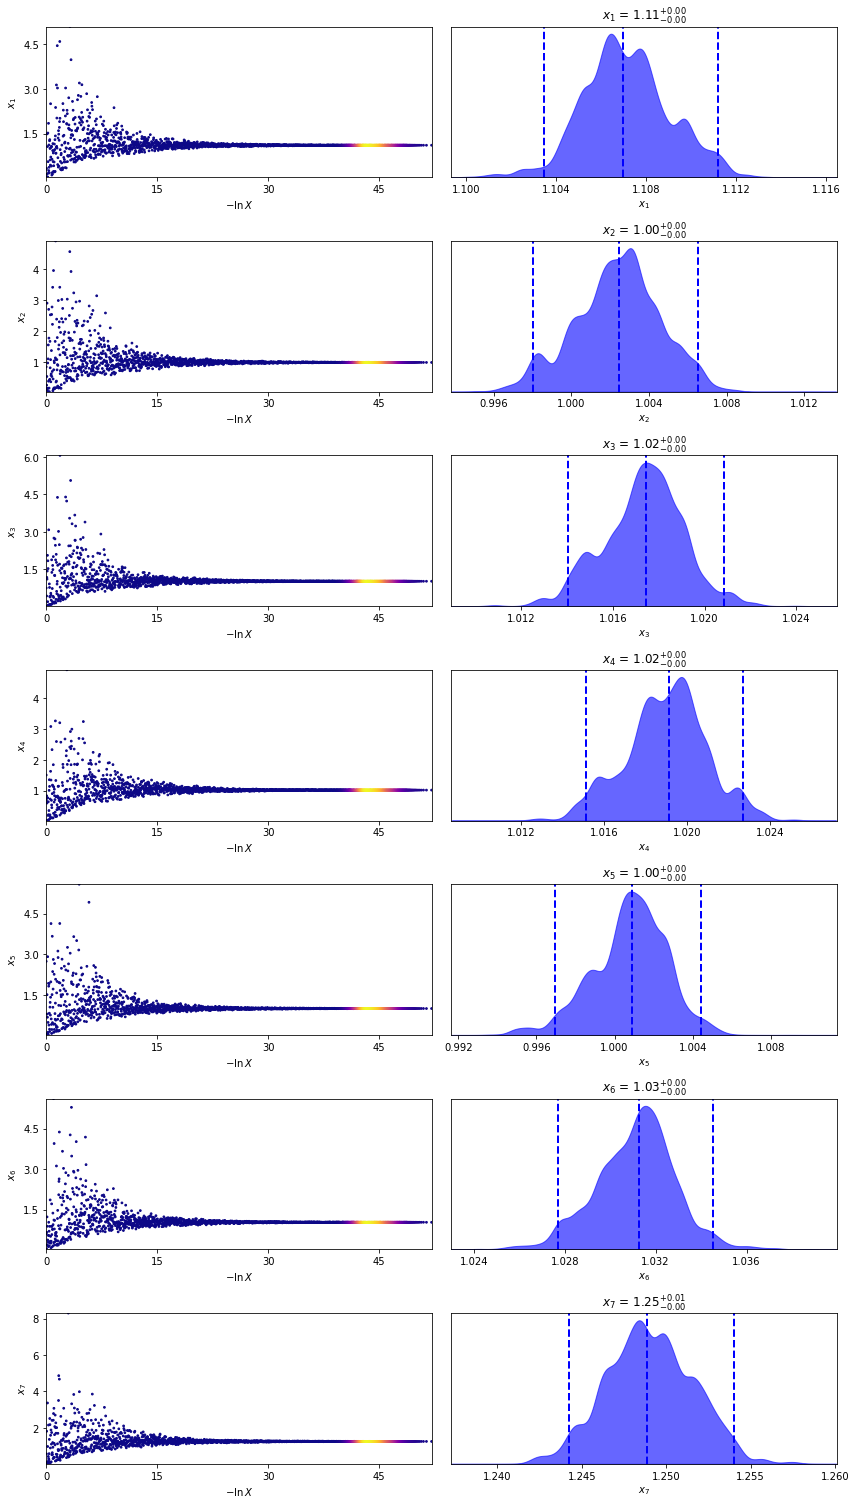

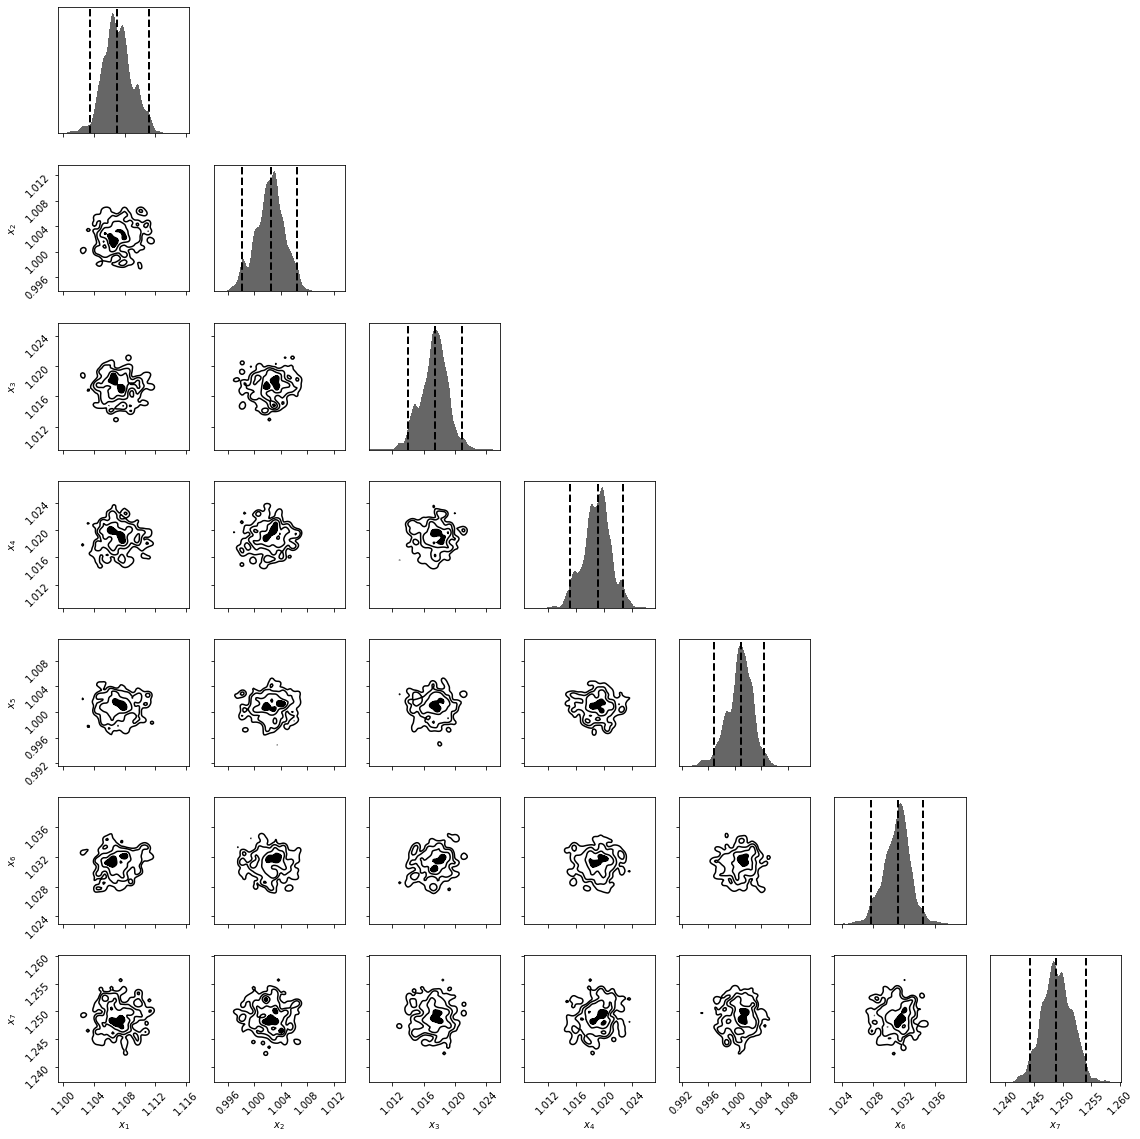

In [136]:
from lib import util
util.dyplot(results)

In [138]:
# scatterplot T, F, B and superimpose on Hawks plot above
bb.forward(randn(10, 7))

DeviceArray([[   4.34401503,  593.60172717, 1737.39993871, 3148.1485076 ,
                59.90332378,   43.18737236,  142.72183751],
             [   6.36328859,  356.75554093, 1759.89874875, 2226.91167754,
                34.6418368 ,   49.56016517,   95.02751887],
             [  10.3821192 ,  507.87277667, 1231.05017589, 2347.40778443,
                38.16943177,   24.86964951,   86.05551301],
             [  11.14503531,  679.68252571, 1496.03772203, 2392.13607609,
                28.48041677,   39.58253351,   21.79331588],
             [   7.73018711,  571.4161386 , 1031.47487526, 2298.68828446,
                32.9791691 ,   41.15392502,   50.51464782],
             [  10.69092697,  352.68672904, 1679.42099388, 2645.86237949,
                35.26771492,   50.17823598,  163.93953563],
             [   6.58394958,  632.36548168, 2126.64975835, 2506.56331596,
                31.3520578 ,   85.95296004,   75.23056233],
             [   5.33919628,  623.27336098, 1230.08802826, 236

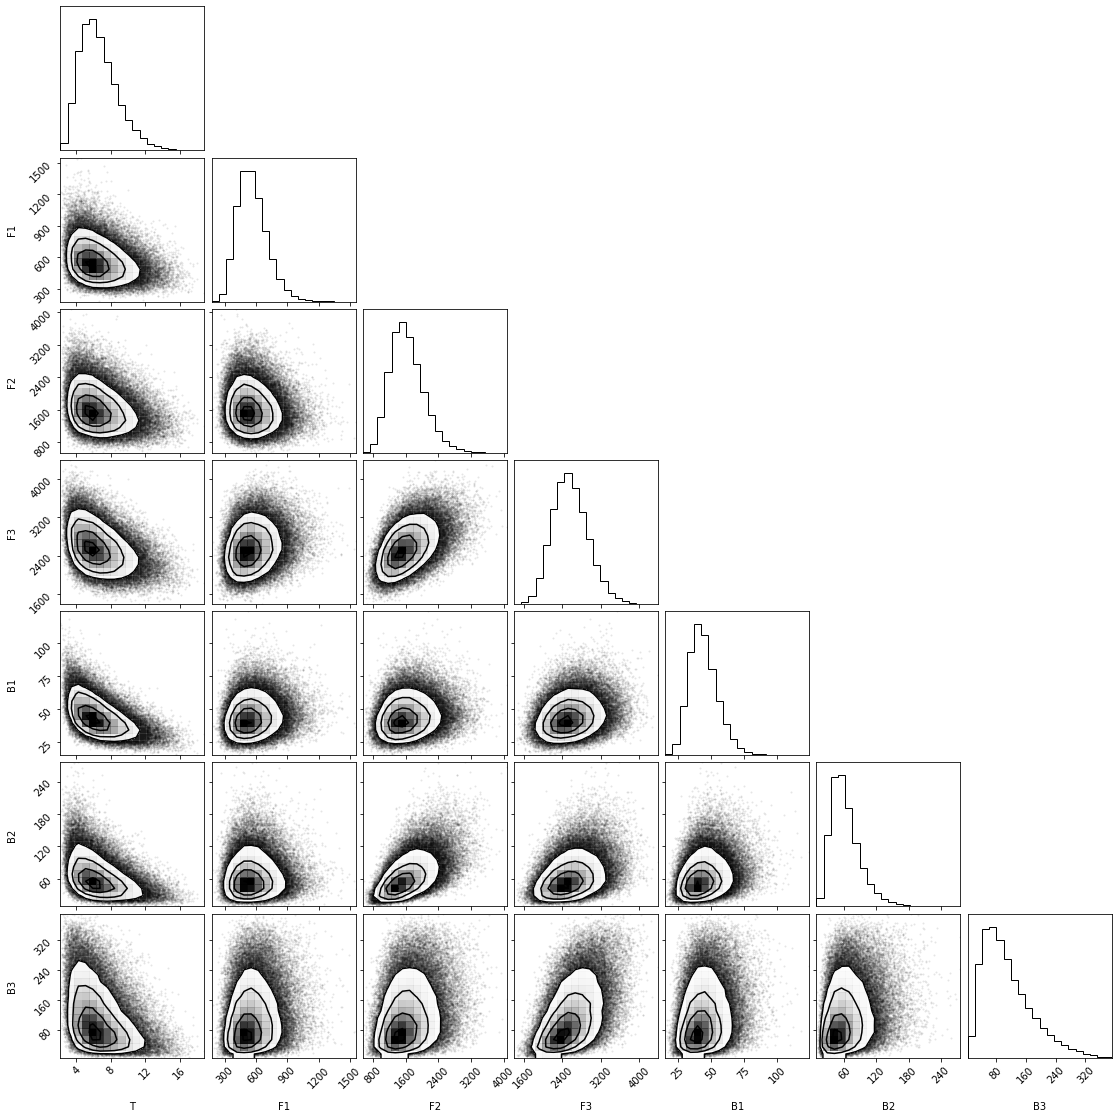

In [140]:
corner.corner(np.array(bb.forward(randn(100000, 7))), labels=("T", "F1", "F2", "F3", "B1", "B2", "B3"));

All good!

In [144]:
kernel_name, _b, results = formant.fit_formants_trajectory_kernel()
formant.maximum_likelihood_envelope_params(results)

(15.239198437183395, 0.00881657240832212)

In [145]:
bbt = bijectors.nonlinear_coloring_trajectory_bijector(
    bb,
    10,
    kernel_name,
    15.239198437183395,
    0.00881657240832212
)

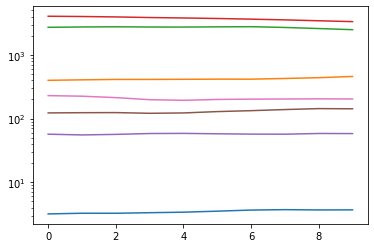

In [148]:
plot(bbt.forward(randn(7*10)))
yscale('log');

In [150]:
bbt.forward(randn(2, 7*10)).shape

(2, 10, 7)